# Kalman Filter Analysis Notebook
This notebook provides analysis of Kalman filter performance.


In [25]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [26]:
"""Simulate LGSSM data for Kalman filter analysis.

This cell generates a 2D latent state trajectory with 2D observations
using a Linear Gaussian State Space Model (LGSSM).

System specification:
- State dimension: 2
- Observation dimension: 2
- Process noise: Diagonal covariance
- Measurement noise: Diagonal covariance
- Time steps: 1000
- Random seed: 42 (for reproducibility)
"""
from simulator.simulator_LGSSM import simulate_lgssm
import numpy as np

# Define system dimensions
nx, ny, nv, nw = 2, 1, 2, 1

# State transition matrix (2x2)
A = np.array([[0.9, 0.5], [0.0, 0.7]])

# Process noise input matrix (2x2)
B = np.diag([np.sqrt(0.05), np.sqrt(0.02)])

# Observation matrix (2x2) - observe both states
C = np.array([[1.0, 0.0],    # observe x1
              [0.0, 1.0]])    # observe x2

# Measurement noise input matrix (2x2)
D = np.array([[np.sqrt(0.10), 0.0],
              [0.0, np.sqrt(0.10)]])

# Initial state covariance
Sigma = np.eye(nx)

# Simulate trajectory
result = simulate_lgssm(A, B, C, D, Sigma, N=1000, seed=42, burn_in=0)
print("X shape:", result.X.shape)
print("Y shape:", result.Y.shape)

# Save to file
result.to_file("../simulator/data/lgssm_simul_data", format="npz", overwrite=True)
print("Simulation complete. Data saved as 'lgssm_simul_data.npz'")


X shape: (1000, 2)
Y shape: (1000, 2)
Simulation complete. Data saved as 'lgssm_simul_data.npz'


In [27]:
"""Load simulated LGSSM data from NPZ file.

This cell loads the previously simulated trajectory data and system matrices
for use in Kalman filter analysis.

Data includes:
- X_true: True latent states (N x nx)
- Y_obs: Observed outputs (N x ny)
- A, B, C, D: System matrices
"""
# Load simulated LGSSM data
data = np.load("../simulator/data/lgssm_simul_data.npz")
X_true = data["X"]   # true latent states
Y_obs  = data["Y"]   # observed outputs
A = data["A"]        # state transition matrix
B = data["B"]        # process-noise input matrix
C = data["C"]        # observation matrix
D = data["D"]        # measurement-noise input matrix

print(f"Loaded data: X_true shape={X_true.shape}, Y_obs shape={Y_obs.shape}")
print(f"System matrices: A={A.shape}, B={B.shape}, C={C.shape}, D={D.shape}")


Loaded data: X_true shape=(1000, 2), Y_obs shape=(1000, 2)
System matrices: A=(2, 2), B=(2, 2), C=(2, 2), D=(2, 2)


In [28]:
"""Compute covariance matrices from system matrices.

This cell derives:
- Q: Process noise covariance (Q = B @ B.T)
- R: Measurement noise covariance (R = D @ D.T)
- Gamma: Process noise input matrix (identity for standard form)

These matrices are used as input to the Kalman filter.
"""
# Compute Q, R, and Gamma from the loaded system matrices
Q = B @ B.T          # process-noise covariance
R = D @ D.T          # measurement-noise covariance
Gamma = np.eye(A.shape[0])   # process-noise input identity

print("Q (process noise covariance):\n", Q)
print("\nR (measurement noise covariance):\n", R)
print("\nA (state transition):\n", A)
print("\nC (observation matrix):\n", C)


Q (process noise covariance):
 [[0.05 0.  ]
 [0.   0.02]]

R (measurement noise covariance):
 [[0.1 0. ]
 [0.  0.1]]

A (state transition):
 [[0.9 0.5]
 [0.  0.7]]

C (observation matrix):
 [[1. 0.]
 [0. 1.]]


This section computes baseline metrics for both Standard and Joseph filter forms.


In [ ]:
"""Compute baseline metrics for Standard and Joseph forms.

This cell runs both filter variants on the baseline data and computes
key metrics needed for comparison:
- Minimum eigenvalues (for PSD validation)
- NEES statistics
- Condition numbers
"""
from models.kalman_filter import kalman_filter_general
# Run Standard form
res_std = kalman_filter_general(
    Y=Y_obs, Phi=A, H=C, Gamma=Gamma, Q=Q, R=R,
    x0=np.zeros(A.shape[0]), P0=Sigma, use_joseph=False
)

# Run Joseph form
res_jos = kalman_filter_general(
    Y=Y_obs, Phi=A, H=C, Gamma=Gamma, Q=Q, R=R,
    x0=np.zeros(A.shape[0]), P0=Sigma, use_joseph=True
)

# Compute errors and NEES
errors = X_true - res_std.x_filt
N = len(errors)
nees = np.zeros(N)
for k in range(N):
    err_k = errors[k].reshape(-1, 1)
    P_inv = np.linalg.inv(res_std.P_filt[k] + 1e-10 * np.eye(2))
    nees[k] = float(err_k.T @ P_inv @ err_k)

mean_nees = np.mean(nees)

# Compute condition numbers and eigenvalues
cond_P = np.array([np.linalg.cond(Pk) for Pk in res_std.P_filt])
min_eigs_std = np.array([np.linalg.eigvalsh(Pk).min() for Pk in res_std.P_filt])
min_eigs_jos = np.array([np.linalg.eigvalsh(Pk).min() for Pk in res_jos.P_filt])

print("="*80)
print("BASELINE ANALYSIS")
print("="*80)
print(f"Mean NEES: {mean_nees:.3f} (expected ~2.0 for nx=2)")
print(f"NEES in 95% CI: {100 * np.sum((nees >= 0.051) & (nees <= 7.378)) / N:.1f}%")
print(f"\nStandard form:")
print(f"  Min eigenvalue: {min_eigs_std.min():.2e}")
print(f"  PSD violations: {np.sum(min_eigs_std < -1e-12)}")
print(f"  Mean cond(P): {np.mean(cond_P):.2f}")
print(f"\nJoseph form:")
print(f"  Min eigenvalue: {min_eigs_jos.min():.2e}")
print(f"  PSD violations: {np.sum(min_eigs_jos < -1e-12)}")
print("\n✓ Baseline metrics computed")


BASELINE ANALYSIS
Mean NEES: 2.189 (expected ~2.0 for nx=2)
NEES in 95% CI: 93.5%

Standard form:
  Min eigenvalue: 2.30e-02
  PSD violations: 0
  Mean cond(P): 2.19

Joseph form:
  Min eigenvalue: 2.30e-02
  PSD violations: 0

✓ Baseline metrics computed


/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_96712/3938267726.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nees[k] = float(err_k.T @ P_inv @ err_k)


As the results obtained from the baseline and the one with Joseph update is the same, we plot the orginal data and filtered estimates only for Standard form results in the following.

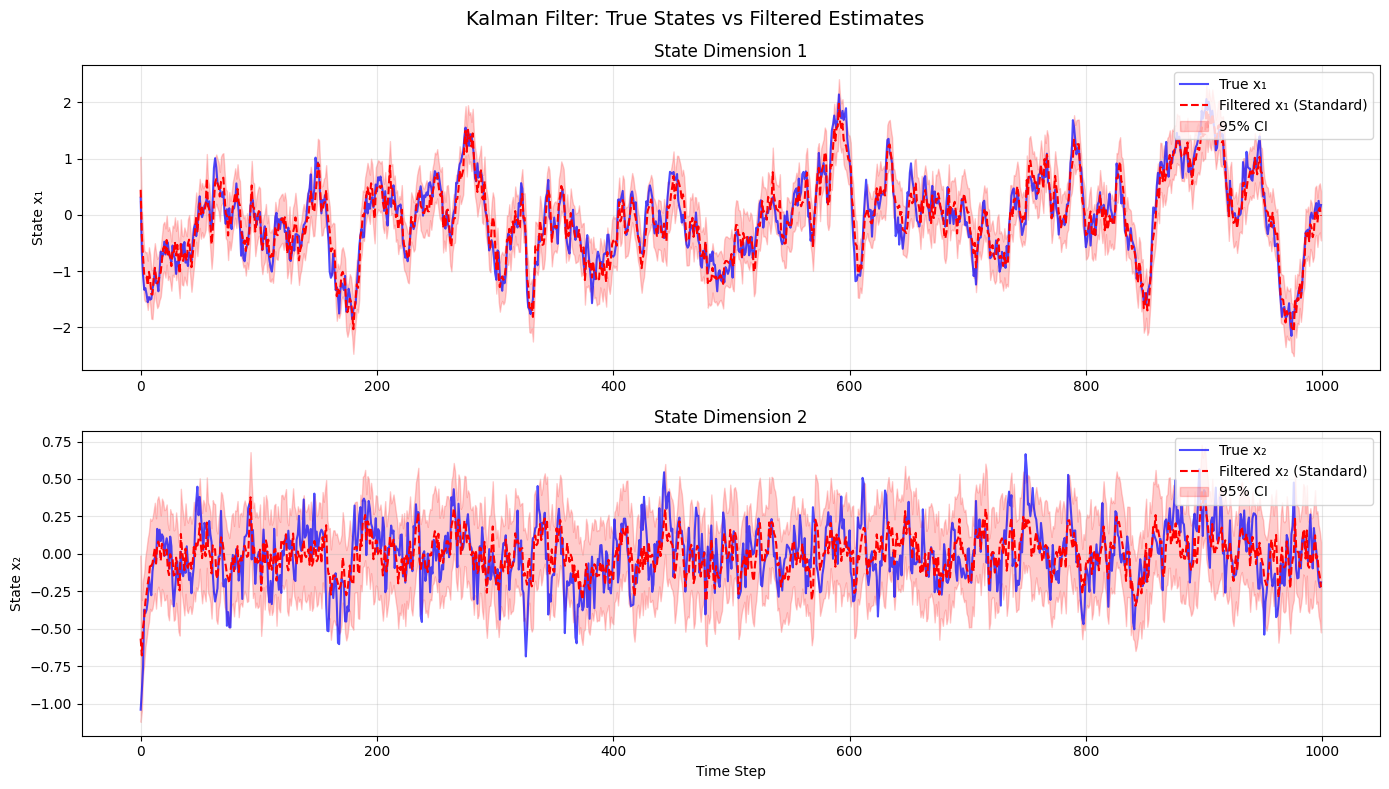

✓ Visualization complete


In [ ]:
"""Visualize original data and filtered estimates.

This cell creates time series plots showing:
- True latent states
- Filtered state estimates (Standard form)
- 95% confidence bands
"""
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle("Kalman Filter: True States vs Filtered Estimates", fontsize=14)

time_steps = np.arange(len(X_true))

# Plot state x1
axes[0].plot(time_steps, X_true[:, 0], 'b-', label='True x₁', linewidth=1.5, alpha=0.7)
axes[0].plot(time_steps, res_std.x_filt[:, 0], 'r--', label='Filtered x₁ (Standard)', linewidth=1.5)

# Add 95% confidence bands (±1.96 * sqrt(P_k[0,0]))
std_x1 = np.array([np.sqrt(res_std.P_filt[k][0, 0]) for k in range(len(X_true))])
axes[0].fill_between(time_steps, 
                      res_std.x_filt[:, 0] - 1.96 * std_x1,
                      res_std.x_filt[:, 0] + 1.96 * std_x1,
                      color='r', alpha=0.2, label='95% CI')

axes[0].set_ylabel('State x₁')
axes[0].set_title('State Dimension 1')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Plot state x2
axes[1].plot(time_steps, X_true[:, 1], 'b-', label='True x₂', linewidth=1.5, alpha=0.7)
axes[1].plot(time_steps, res_std.x_filt[:, 1], 'r--', label='Filtered x₂ (Standard)', linewidth=1.5)

# Add 95% confidence bands
std_x2 = np.array([np.sqrt(res_std.P_filt[k][1, 1]) for k in range(len(X_true))])
axes[1].fill_between(time_steps, 
                      res_std.x_filt[:, 1] - 1.96 * std_x2,
                      res_std.x_filt[:, 1] + 1.96 * std_x2,
                      color='r', alpha=0.2, label='95% CI')

axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('State x₂')
axes[1].set_title('State Dimension 2')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")


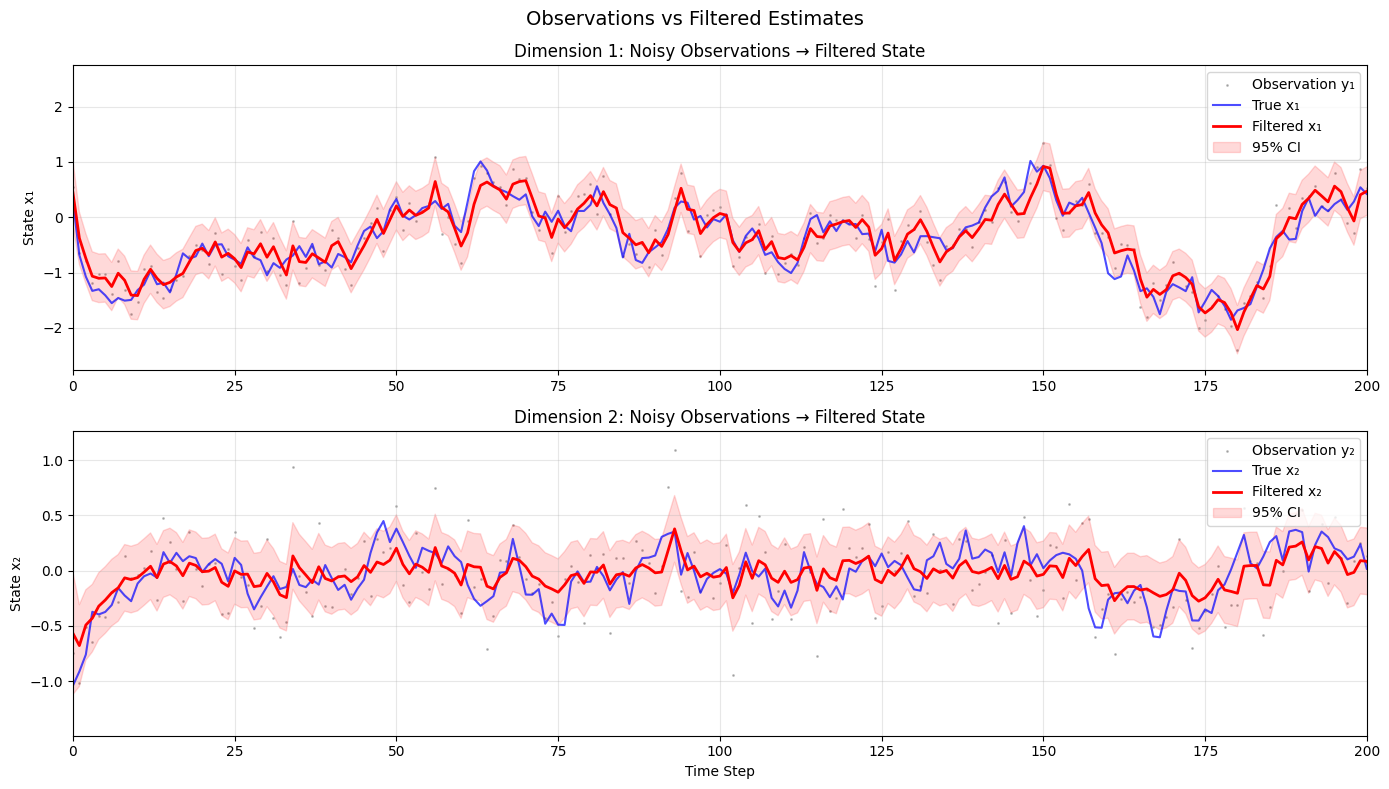

✓ Observations visualization complete


In [ ]:
"""Visualize observations and filtered estimates for first 200 steps.

This cell shows the relationship between noisy observations and 
the filtered state estimates with uncertainty quantification.
"""
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle("Observations vs Filtered Estimates", fontsize=14)

time_steps = np.arange(len(X_true))

# Plot observation 1 vs filtered state 1
axes[0].scatter(time_steps, Y_obs[:, 0], c='gray', s=1, alpha=0.5, label='Observation y₁')
axes[0].plot(time_steps, X_true[:, 0], 'b-', label='True x₁', linewidth=1.5, alpha=0.7)
axes[0].plot(time_steps, res_std.x_filt[:, 0], 'r-', label='Filtered x₁', linewidth=2)

std_x1 = np.array([np.sqrt(res_std.P_filt[k][0, 0]) for k in range(len(X_true))])
axes[0].fill_between(time_steps, 
                      res_std.x_filt[:, 0] - 1.96 * std_x1,
                      res_std.x_filt[:, 0] + 1.96 * std_x1,
                      color='r', alpha=0.15, label='95% CI')

axes[0].set_ylabel('State x₁')
axes[0].set_title('Dimension 1: Noisy Observations → Filtered State')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 200])  # Zoom to first 200 steps for clarity

# Plot observation 2 vs filtered state 2
axes[1].scatter(time_steps, Y_obs[:, 1], c='gray', s=1, alpha=0.5, label='Observation y₂')
axes[1].plot(time_steps, X_true[:, 1], 'b-', label='True x₂', linewidth=1.5, alpha=0.7)
axes[1].plot(time_steps, res_std.x_filt[:, 1], 'r-', label='Filtered x₂', linewidth=2)

std_x2 = np.array([np.sqrt(res_std.P_filt[k][1, 1]) for k in range(len(X_true))])
axes[1].fill_between(time_steps, 
                      res_std.x_filt[:, 1] - 1.96 * std_x2,
                      res_std.x_filt[:, 1] + 1.96 * std_x2,
                      color='r', alpha=0.15, label='95% CI')

axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('State x₂')
axes[1].set_title('Dimension 2: Noisy Observations → Filtered State')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 200])  # Zoom to first 200 steps for clarity

plt.tight_layout()
plt.show()

print("✓ Observations visualization complete")



The Monte Carlo and Boundary tests will reveal differences under more challenging conditions.


In [30]:
"""Consolidated imports and utility functions for Kalman filter analysis.

This module provides helper functions for computing key metrics used in
validating filter optimality and numerical stability.
"""
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict


def compute_filter_metrics(res_filt, X_true, nx=2):
    """Compute comprehensive filter performance metrics.
    
    Parameters
    ----------
    res_filt : KFResults
        Kalman filter results object containing filtered states and covariances.
    X_true : np.ndarray
        True latent states, shape (N, nx).
    nx : int, optional
        Dimension of state vector, default is 2.
    
    Returns
    -------
    dict
        Dictionary containing:
        - rmse: Root mean squared error per state dimension
        - nees: Normalized estimation error squared at each time step
        - mean_nees: Average NEES across all time steps
        - nees_in_ci: Percentage of NEES values within 95% CI for χ²(2)
        - cond_S: Condition numbers of innovation covariance S_k
        - cond_P: Condition numbers of filtered covariance P_k
        - mean_cond_S: Average condition number of S_k
        - mean_cond_P: Average condition number of P_k
        - max_cond_P: Maximum condition number of P_k
        - min_eigs: Minimum eigenvalues of P_k at each time step
        - psd_violations: Count of negative eigenvalues (PSD violations)
        - loglik: Log-likelihood of the filter
    
    Notes
    -----
    NEES should follow χ²(nx) distribution under optimal filtering.
    For nx=2, 95% CI is approximately [0.051, 7.378].
    """
    errors = X_true - res_filt.x_filt
    rmse = np.sqrt(np.mean(errors**2, axis=0))
    
    # Compute NEES: ε_k^T P_k^{-1} ε_k ~ χ²(nx)
    N = len(errors)
    nees = np.zeros(N)
    for k in range(N):
        err_k = errors[k].reshape(-1, 1)
        P_inv = np.linalg.inv(res_filt.P_filt[k] + 1e-10 * np.eye(nx))
        nees[k] = float(err_k.T @ P_inv @ err_k)
    
    # Condition numbers and eigenvalues for numerical stability
    cond_S = np.array([np.linalg.cond(Sk) for Sk in res_filt.S])
    cond_P = np.array([np.linalg.cond(Pk) for Pk in res_filt.P_filt])
    min_eigs = np.array([np.linalg.eigvalsh(Pk).min() for Pk in res_filt.P_filt])
    
    return {
        'rmse': rmse,
        'nees': nees,
        'mean_nees': np.mean(nees),
        'nees_in_ci': 100 * np.sum((nees >= 0.051) & (nees <= 7.378)) / N,
        'cond_S': cond_S,
        'cond_P': cond_P,
        'mean_cond_S': np.mean(cond_S),
        'mean_cond_P': np.mean(cond_P),
        'max_cond_P': np.max(cond_P),
        'min_eigs': min_eigs,
        'psd_violations': np.sum(min_eigs < -1e-12),
        'loglik': res_filt.loglik
    }


print("✓ Utilities loaded")


✓ Utilities loaded


                         MONTE CARLO ANALYSIS
[1/10] Seed 42... ✓
[2/10] Seed 123... 

/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_96712/2419400401.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nees[k] = float(err_k.T @ P_inv @ err_k)


✓
[3/10] Seed 456... ✓
[4/10] Seed 789... ✓
[5/10] Seed 1024... ✓
[6/10] Seed 2048... ✓
[5/10] Seed 1024... ✓
[6/10] Seed 2048... ✓
[7/10] Seed 3141... ✓
[8/10] Seed 5926... ✓
[7/10] Seed 3141... ✓
[8/10] Seed 5926... ✓
[9/10] Seed 8888... ✓
[10/10] Seed 9999... ✓
[9/10] Seed 8888... ✓
[10/10] Seed 9999... ✓

SUMMARY STATISTICS:
Mean NEES:      Std=2.052, Jos=2.052
Mean RMSE:      Std=0.1915, Jos=0.1915
PSD violations: Std=0, Jos=0
Mean cond(P):   Std=2.19, Jos=2.19
✓

SUMMARY STATISTICS:
Mean NEES:      Std=2.052, Jos=2.052
Mean RMSE:      Std=0.1915, Jos=0.1915
PSD violations: Std=0, Jos=0
Mean cond(P):   Std=2.19, Jos=2.19


/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_96712/3392776482.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([mc_data['std']['mean_nees'], mc_data['jos']['mean_nees']],
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_96712/3392776482.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([mc_data['std']['rmse'], mc_data['jos']['rmse']],


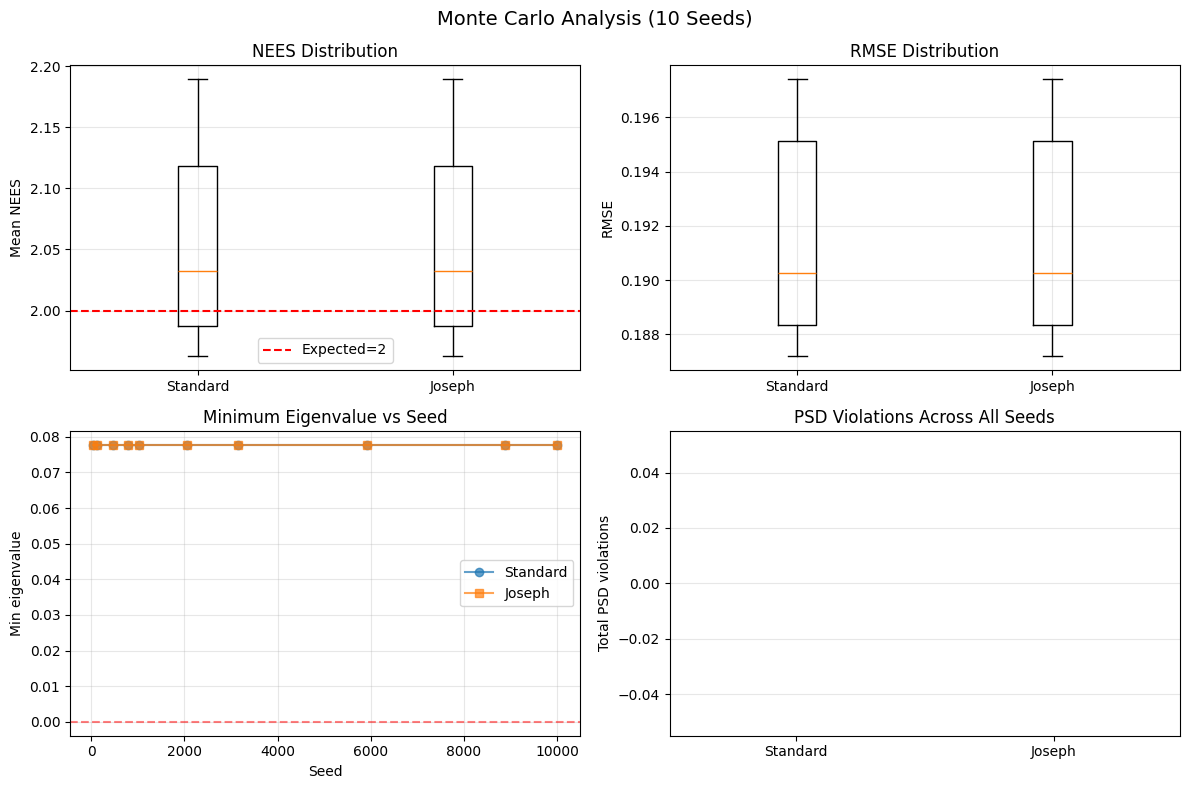


✓ Monte Carlo analysis complete: 10 seeds × 2 methods = 20 runs


In [31]:
"""Monte Carlo robustness analysis for Kalman filter validation.

This cell performs Monte Carlo simulation across multiple random seeds to validate:
1. Consistency of filter performance across different realizations
2. Robustness of Standard vs Joseph form implementations
3. Statistical properties (NEES, RMSE) under optimal filtering

The analysis tests 10 independent seeds with both filter variants.
"""
print("="*80)
print(" "*25 + "MONTE CARLO ANALYSIS")
print("="*80)

# Configuration
seeds_mc = [42, 123, 456, 789, 1024, 2048, 3141, 5926, 8888, 9999]
N_mc = 1000

# Storage
mc_data = {'seed': [], 'std': defaultdict(list), 'jos': defaultdict(list)}

# Run Monte Carlo simulations
for i, seed in enumerate(seeds_mc):
    print(f"[{i+1}/{len(seeds_mc)}] Seed {seed}...", end=" ")
    
    # Simulate LGSSM trajectory
    result_mc = simulate_lgssm(A, B, C, D, Sigma, N=N_mc, seed=seed, burn_in=0)
    
    # Run both filter variants
    for use_joseph, label in [(False, 'std'), (True, 'jos')]:
        res_mc = kalman_filter_general(result_mc.Y, A, C, Gamma, Q, R,
                                       x0=np.zeros(2), P0=Sigma, use_joseph=use_joseph)
        metrics = compute_filter_metrics(res_mc, result_mc.X)
        
        # Store all metrics
        for key, val in metrics.items():
            if isinstance(val, np.ndarray) and len(val.shape) > 0:
                mc_data[label][key].append(np.mean(val) if key in ['rmse', 'cond_S', 'cond_P'] else val[0])
            else:
                mc_data[label][key].append(val)
    
    mc_data['seed'].append(seed)
    print("✓")

# Convert lists to arrays for vectorized operations
for label in ['std', 'jos']:
    for key in mc_data[label]:
        mc_data[label][key] = np.array(mc_data[label][key])

# Display summary statistics
print(f"\n{'='*80}")
print("SUMMARY STATISTICS:")
print(f"{'='*80}")
print(f"Mean NEES:      Std={np.mean(mc_data['std']['mean_nees']):.3f}, Jos={np.mean(mc_data['jos']['mean_nees']):.3f}")
print(f"Mean RMSE:      Std={np.mean(mc_data['std']['rmse']):.4f}, Jos={np.mean(mc_data['jos']['rmse']):.4f}")
print(f"PSD violations: Std={np.sum(mc_data['std']['psd_violations']):.0f}, Jos={np.sum(mc_data['jos']['psd_violations']):.0f}")
print(f"Mean cond(P):   Std={np.mean(mc_data['std']['mean_cond_P']):.2f}, Jos={np.mean(mc_data['jos']['mean_cond_P']):.2f}")

# Create visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Monte Carlo Analysis (10 Seeds)", fontsize=14)

# Plot 1: NEES distribution
axes[0, 0].boxplot([mc_data['std']['mean_nees'], mc_data['jos']['mean_nees']], 
                    labels=['Standard', 'Joseph'])
axes[0, 0].axhline(2, color='r', linestyle='--', label='Expected=2')
axes[0, 0].set_ylabel('Mean NEES')
axes[0, 0].set_title('NEES Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: RMSE distribution
axes[0, 1].boxplot([mc_data['std']['rmse'], mc_data['jos']['rmse']], 
                    labels=['Standard', 'Joseph'])
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE Distribution')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Minimum eigenvalue vs seed
min_eig_std = [np.min(mc_data['std']['min_eigs'][i]) for i in range(len(seeds_mc))]
min_eig_jos = [np.min(mc_data['jos']['min_eigs'][i]) for i in range(len(seeds_mc))]
axes[1, 0].plot(seeds_mc, min_eig_std, 'o-', label='Standard', alpha=0.7)
axes[1, 0].plot(seeds_mc, min_eig_jos, 's-', label='Joseph', alpha=0.7)
axes[1, 0].axhline(0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Seed')
axes[1, 0].set_ylabel('Min eigenvalue')
axes[1, 0].set_title('Minimum Eigenvalue vs Seed')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: PSD violations count
axes[1, 1].bar(['Standard', 'Joseph'], 
               [np.sum(mc_data['std']['psd_violations']), 
                np.sum(mc_data['jos']['psd_violations'])],
               color=['C0', 'C1'], alpha=0.7)
axes[1, 1].set_ylabel('Total PSD violations')
axes[1, 1].set_title('PSD Violations Across All Seeds')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Monte Carlo analysis complete: {len(seeds_mc)} seeds × 2 methods = {len(seeds_mc)*2} runs")


                         BOUNDARY TESTING

Near-Perfect R: R → 0 (very confident measurements)
  Std: min_eig=1.00e-08, PSD_viol=0, max_cond=1.00e+00
  Jos: min_eig=1.00e-08, PSD_viol=0, max_cond=1.00e+00

Near-Zero Q: Q → 0 (deterministic dynamics)
  Std: min_eig=1.73e-08, PSD_viol=0, max_cond=3.13e+04


/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_96712/2419400401.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nees[k] = float(err_k.T @ P_inv @ err_k)


  Jos: min_eig=1.73e-08, PSD_viol=0, max_cond=3.13e+04

High Noise: R >> baseline (low SNR)
  Std: min_eig=3.57e-02, PSD_viol=0, max_cond=2.49e+01
  Jos: min_eig=3.57e-02, PSD_viol=0, max_cond=2.49e+01

Unstable: max|eig(A)| > 1 (unstable dynamics)
  Std: min_eig=3.62e-02, PSD_viol=0, max_cond=1.55e+00
  Jos: min_eig=3.62e-02, PSD_viol=0, max_cond=1.55e+00

Partial Obs: Observe only x₁ (rank-deficient)
  Std: min_eig=3.24e-02, PSD_viol=0, max_cond=4.62e+00
  Jos: min_eig=3.24e-02, PSD_viol=0, max_cond=4.62e+00

BOUNDARY TEST SUMMARY:
      Scenario  Std_min_eig  Jos_min_eig  Std_PSD_viol  Jos_PSD_viol
Near-Perfect R 1.000099e-08 9.999995e-09             0             0
   Near-Zero Q 1.729879e-08 1.729879e-08             0             0
    High Noise 3.565422e-02 3.565422e-02             0             0
      Unstable 3.618845e-02 3.618845e-02             0             0
   Partial Obs 3.235811e-02 3.235811e-02             0             0
  Jos: min_eig=3.62e-02, PSD_viol=0, max_cond=

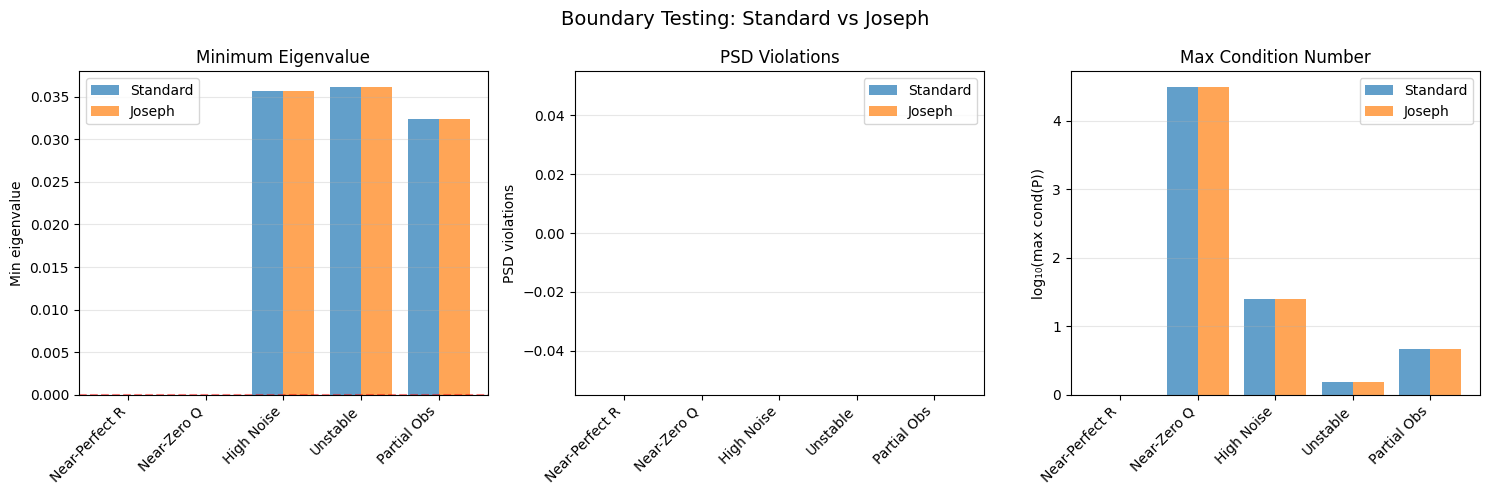


✓ Boundary testing complete: 5 scenarios × 2 methods


In [32]:
"""Boundary and edge case testing for numerical stability validation.

This cell tests filter behavior under extreme conditions:
1. Near-Perfect R: R → 0 (very confident measurements)
2. Near-Zero Q: Q → 0 (deterministic dynamics)
3. High Noise: R >> baseline (low signal-to-noise ratio)
4. Unstable: max|eig(A)| > 1 (unstable system dynamics)
5. Partial Obs: Rank-deficient observation matrix

These scenarios stress-test PSD maintenance and numerical stability.
"""
print("="*80)
print(" "*25 + "BOUNDARY TESTING")
print("="*80)

# Define extreme test scenarios
scenarios_boundary = {
    'Near-Perfect R': {
        'D': np.array([[np.sqrt(1e-8), 0.0], [0.0, np.sqrt(1e-8)]]),
        'desc': 'R → 0 (very confident measurements)'
    },
    'Near-Zero Q': {
        'B': np.diag([np.sqrt(1e-8), np.sqrt(1e-8)]),
        'desc': 'Q → 0 (deterministic dynamics)'
    },
    'High Noise': {
        'D': np.array([[np.sqrt(10.0), 0.0], [0.0, np.sqrt(10.0)]]),
        'desc': 'R >> baseline (low SNR)'
    },
    'Unstable': {
        'A': np.array([[1.1, 0.3], [0.0, 1.05]]),
        'desc': 'max|eig(A)| > 1 (unstable dynamics)'
    },
    'Partial Obs': {
        'C': np.array([[1.0, 0.0]]),
        'D': np.array([[np.sqrt(0.10)]]),
        'desc': 'Observe only x₁ (rank-deficient)'
    }
}

# Baseline system matrices
A_bl, B_bl, C_bl, D_bl = A, B, C, D

# Storage for test results
boundary_data = []

# Execute boundary tests
for name, config in scenarios_boundary.items():
    print(f"\n{name}: {config['desc']}")
    
    # Configure test-specific matrices (use baseline for unspecified)
    A_test = config.get('A', A_bl)
    B_test = config.get('B', B_bl)
    C_test = config.get('C', C_bl)
    D_test = config.get('D', D_bl)
    Q_test, R_test = B_test @ B_test.T, D_test @ D_test.T
    Gamma_test = np.eye(A_test.shape[0])
    
    # Simulate trajectory under boundary conditions
    try:
        result_boundary = simulate_lgssm(A_test, B_test, C_test, D_test, Sigma, 
                                         N=1000, seed=42, burn_in=100)
        
        row = {'Scenario': name, 'Description': config['desc']}
        
        # Test both Standard and Joseph forms
        for use_joseph, label in [(False, 'Std'), (True, 'Jos')]:
            try:
                res_boundary = kalman_filter_general(
                    result_boundary.Y, A_test, C_test, Gamma_test, Q_test, R_test,
                    x0=np.zeros(A_test.shape[0]), P0=Sigma, 
                    use_joseph=use_joseph, jitter=1e-12
                )
                metrics_boundary = compute_filter_metrics(
                    res_boundary, result_boundary.X, A_test.shape[0]
                )
                
                # Store key stability metrics
                row[f'{label}_min_eig'] = metrics_boundary['min_eigs'].min()
                row[f'{label}_PSD_viol'] = metrics_boundary['psd_violations']
                row[f'{label}_max_cond'] = metrics_boundary['max_cond_P']
                row[f'{label}_success'] = True
                
                print(f"  {label}: min_eig={metrics_boundary['min_eigs'].min():.2e}, "
                      f"PSD_viol={metrics_boundary['psd_violations']}, "
                      f"max_cond={metrics_boundary['max_cond_P']:.2e}")
            except Exception as e:
                row[f'{label}_success'] = False
                print(f"  {label}: FAILED - {e}")
        
        boundary_data.append(row)
        
    except Exception as e:
        print(f"  Simulation failed: {e}")

# Create comparison DataFrame
df_boundary_compact = pd.DataFrame(boundary_data)

print(f"\n{'='*80}")
print("BOUNDARY TEST SUMMARY:")
print(f"{'='*80}")
print(df_boundary_compact[['Scenario', 'Std_min_eig', 'Jos_min_eig', 
                            'Std_PSD_viol', 'Jos_PSD_viol']].to_string(index=False))

# Create visualization dashboard
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Boundary Testing: Standard vs Joseph", fontsize=14)

scenarios_plot = df_boundary_compact['Scenario'].values
x_pos = np.arange(len(scenarios_plot))

# Plot 1: Minimum eigenvalue comparison
axes[0].bar(x_pos - 0.2, df_boundary_compact['Std_min_eig'], 0.4, 
            label='Standard', alpha=0.7)
axes[0].bar(x_pos + 0.2, df_boundary_compact['Jos_min_eig'], 0.4, 
            label='Joseph', alpha=0.7)
axes[0].axhline(0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(scenarios_plot, rotation=45, ha='right')
axes[0].set_ylabel('Min eigenvalue')
axes[0].set_title('Minimum Eigenvalue')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Plot 2: PSD violations count
axes[1].bar(x_pos - 0.2, df_boundary_compact['Std_PSD_viol'], 0.4, 
            label='Standard', alpha=0.7)
axes[1].bar(x_pos + 0.2, df_boundary_compact['Jos_PSD_viol'], 0.4, 
            label='Joseph', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(scenarios_plot, rotation=45, ha='right')
axes[1].set_ylabel('PSD violations')
axes[1].set_title('PSD Violations')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

# Plot 3: Maximum condition number (log scale)
axes[2].bar(x_pos - 0.2, np.log10(df_boundary_compact['Std_max_cond']), 0.4, 
            label='Standard', alpha=0.7)
axes[2].bar(x_pos + 0.2, np.log10(df_boundary_compact['Jos_max_cond']), 0.4, 
            label='Joseph', alpha=0.7)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(scenarios_plot, rotation=45, ha='right')
axes[2].set_ylabel('log₁₀(max cond(P))')
axes[2].set_title('Max Condition Number')
axes[2].legend()
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Boundary testing complete: {len(scenarios_boundary)} scenarios × 2 methods")
